In [ ]:
#hide
#from your_lib.core import *

# `deepfeatx`: Deep Learning Feature Extractor of Images using Transfer Learning Models

> Helper for automatic extraction of features from images (and soon text as well) from transfer learning models like ResNet, VGG16 and EfficientNet.

## Install

In [ ]:
#hide_output
!pip install deepfeatx

## Why this project has been created
- Fill the gap between ML and DL thus allowing estimators beyond only neural networks for computer vision and NLP problems
- Neural network models are too painful to setup and train - data generators, optimizers, learning rates, loss functions, training loops, batch size, etc. 
- State of the art results are possible thanks to pretrained models that allows feature extraction
- With this library we can handle those problems as they were traditional machine learning problems
- Possibility of using low-code APIs like `scikit-learn` for computer vision and NLP problems

## Usage
### Extracting features from an image

`deepfeatx` allows extracting features from the models 'efficientnetb0', 'efficientnetb4', 'efficientnetb7' and 'resnet50'. As default we are using Resnet50 but you can also specify different models as the class input:

In [ ]:
#hide_output
from deepfeatx.image import ImageFeatureExtractor
fe = ImageFeatureExtractor('efficientnetb4')

Next, let's transform the following URL into a vector:

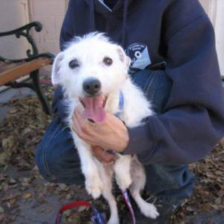

In [ ]:
im_url='https://raw.githubusercontent.com/WittmannF/deepfeatx/master/sample_data/cats_vs_dogs/valid/dog/dog.124.jpg'
fe.read_img_url(im_url)

In [ ]:
fe.url_to_vector(im_url)

array([[-0.19569655,  0.01385073, -0.18466987, ..., -0.18626775,
         0.24537565,  0.03650745]], dtype=float32)

### Extracting Features from a Folder with Images

In [ ]:
#hide_output
!git clone https://github.com/WittmannF/image-scraper.git

fatal: destination path 'image-scraper' already exists and is not an empty directory.


In [ ]:
df=fe.extract_features_from_directory('image-scraper/images/pug',
                                   classes_as_folders=False,
                                   export_vectors_as_df=True)

df.head()

Found 4 validated image filenames.
1/1 [==============================] - 0s 89ms/step


,filepaths,0,1,2,3,4,5,6,7,8,...,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791
0,image-scraper/images/pug/efd08a2dc5.jpg,-0.053781,-0.201073,-0.109230,0.032315,-0.154896,-0.163725,-0.233414,-0.199399,-0.207240,...,-0.184487,-0.191406,-0.158955,0.106836,0.073545,0.519778,-0.221428,-0.187045,-0.086689,-0.228142
1,image-scraper/images/pug/24d0f1eee3.jpg,-0.179735,-0.149042,-0.099841,-0.043361,-0.176758,-0.191918,-0.232161,-0.136291,-0.212060,...,-0.075074,-0.171430,-0.185827,0.104012,-0.179634,0.252138,-0.235885,-0.064212,-0.009336,-0.150108
2,image-scraper/images/pug/6fb189ce56.jpg,-0.188432,-0.128387,-0.153920,0.126379,-0.090949,-0.178837,-0.169744,-0.131994,-0.176617,...,0.470620,-0.133934,0.057369,0.198847,1.394713,-0.043932,-0.185945,-0.094914,-0.144376,0.320053
3,image-scraper/images/pug/ee815ebc87.jpg,-0.108604,-0.076769,-0.191977,-0.003384,-0.160474,-0.008317,-0.222178,-0.157181,-0.205097,...,0.162647,-0.003036,-0.095424,0.039418,-0.083985,0.276322,-0.185036,-0.169026,0.432216,0.229381


### Extracting Features from a directory having one sub-folder per class

If the directory structure is the following:
```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```
We can enter `main_directory` as input by changing `classes_as_folders` as True:

In [ ]:
df=fe.extract_features_from_directory('image-scraper/images/',
                                      classes_as_folders=True,
                                      export_vectors_as_df=True,
                                      export_class_names=True)

df.head()

Found 504 images belonging to 6 classes.
16/16 [==============================] - 9s 565ms/step


,filepaths,classes,0,1,2,3,4,5,6,7,...,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791
0,image-scraper/images/chihuahua/00dcf98689.jpg,chihuahua,-0.159810,-0.143636,-0.163834,-0.189329,-0.221989,-0.205568,-0.032348,-0.196095,...,0.187660,0.382510,-0.098162,-0.184861,0.262455,0.031863,-0.142880,-0.176995,-0.137101,-0.197719
1,image-scraper/images/chihuahua/01ee02c2fb.jpg,chihuahua,-0.115785,-0.178243,-0.154352,-0.074939,-0.182898,-0.234842,0.201118,-0.172307,...,0.096958,-0.147701,-0.117756,-0.172870,0.753768,-0.196702,-0.142921,-0.159372,-0.219529,-0.172731
2,image-scraper/images/chihuahua/040df01fb4.jpg,chihuahua,-0.224309,-0.140264,-0.221784,0.082428,0.034317,-0.244586,-0.143733,-0.217184,...,0.113856,-0.015320,0.485527,0.115924,0.359226,0.059734,0.705865,-0.108514,-0.211965,-0.201553
3,image-scraper/images/chihuahua/04d8487a97.jpg,chihuahua,0.357453,0.228814,-0.130092,0.076011,-0.097715,0.076276,0.280204,-0.187367,...,0.510490,-0.069560,0.060880,-0.190473,-0.038110,-0.168990,-0.210013,-0.141430,-0.176050,0.030997
4,image-scraper/images/chihuahua/0d9fa44dea.jpg,chihuahua,-0.053391,-0.073038,-0.131840,-0.125724,-0.090771,-0.176459,0.088454,-0.138470,...,0.297104,0.212539,-0.039888,-0.214346,-0.026465,0.059569,-0.172730,-0.144529,0.012751,-0.211402


The usage of `export_class_names=True` will add a new column to the dataframe with the classes names.

## Examples
### Cats vs Dogs using Keras vs `deepfeatx`
First let's compare the code of one of the simplest deep learning libraries (Keras) with `deepfeatx`. As example, let's use a subset of Cats vs Dogs:

In [ ]:
#hide_output
from deepfeatx.image import download_dataset
download_dataset('https://github.com/dl7days/datasets/raw/master/cats-dogs-data.zip', 'cats-dogs-data.zip')

--2021-10-09 13:33:57--  https://github.com/dl7days/datasets/raw/master/cats-dogs-data.zip
Resolving github.com (github.com)... 20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dl7days/datasets/master/cats-dogs-data.zip [following]
--2021-10-09 13:33:58--  https://raw.githubusercontent.com/dl7days/datasets/master/cats-dogs-data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55203029 (53M) [application/zip]
Saving to: ‘cats-dogs-data.zip’

     0K .......... .......... .......... .......... ..........  0% 1,79M 29s
    50K .......... .......... .......... .......... ..........  0% 2,49M 25s
   100K .......... .......... ......

Unzipping Dataset
Archive:  cats-dogs-data.zip
Removing .zip file


........ .......... 96% 11,9M 0s
 52050K .......... .......... .......... .......... .......... 96%  124M 0s
 52100K .......... .......... .......... .......... .......... 96% 61,7M 0s
 52150K .......... .......... .......... .......... .......... 96% 51,7M 0s
 52200K .......... .......... .......... .......... .......... 96% 24,6M 0s
 52250K .......... .......... .......... .......... .......... 97%  133M 0s
 52300K .......... .......... .......... .......... .......... 97% 18,6M 0s
 52350K .......... .......... .......... .......... .......... 97%  112M 0s
 52400K .......... .......... .......... .......... .......... 97% 14,5M 0s
 52450K .......... .......... .......... .......... .......... 97%  211M 0s
 52500K .......... .......... .......... .......... .......... 97% 12,4M 0s
 52550K .......... .......... .......... .......... .......... 97%  136M 0s
 52600K .......... .......... .......... .......... .......... 97% 12,2M 0s
 52650K .......... .......... .......... .......... ...

Here's the keras implementation for a great performance result:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET_SHAPE = (224, 224, 3)
TRAIN_PATH = 'cats-dogs-data/train'
VALID_PATH = 'cats-dogs-data/valid'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = datagen.flow_from_directory(TRAIN_PATH, 
                                        target_size=TARGET_SHAPE[:2], 
                                        class_mode='sparse')
valid_gen = datagen.flow_from_directory(VALID_PATH, 
                                        target_size=TARGET_SHAPE[:2], 
                                        class_mode='sparse',
                                        shuffle=False)

base_model = ResNet50(include_top=False, input_shape=TARGET_SHAPE)

for layer in base_model.layers:
    layer.trainable=False
    
model = Sequential([base_model,
                    GlobalAveragePooling2D(),
                    Dense(1024, activation='relu'),
                    Dense(2, activation='softmax')])

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.fit(train_gen, epochs=3, validation_data=valid_gen)

Epoch 1/3


2021-10-09 13:35:09.882000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.9355

2021-10-09 13:35:33.430145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 29s 435ms/step - loss: 0.5989 - accuracy: 0.9355 - val_loss: 0.1222 - val_accuracy: 0.9750
Epoch 2/3
63/63 [==============================] - 28s 438ms/step - loss: 0.1239 - accuracy: 0.9695 - val_loss: 0.0506 - val_accuracy: 0.9900
Epoch 3/3
63/63 [==============================] - 27s 425ms/step - loss: 0.0941 - accuracy: 0.9795 - val_loss: 0.2257 - val_accuracy: 0.9725


By looking at `val_accuracy` we can confirm the results seems great. Let's also plot some other metrics:

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
y_pred = model.predict(valid_gen)
y_test = valid_gen.classes
roc = roc_auc_score(y_test, y_pred[:, 1])
print("ROC AUC Score", roc)

2021-10-09 13:36:39.564183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


ROC AUC Score 0.99475


<AxesSubplot:>

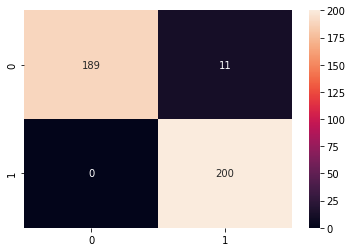

In [ ]:
cm=confusion_matrix(y_test, y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g')

Although we got an almost perfect clssifier, there are multiple details that someone who is coming from sklearn has to be careful when using Keras, for example:
- Correctly setup the Data Generator
- Select the optimizer and a learning rate
- Adjust the batch size

Now let's replicate the same results using `deepfeatx`:

In [ ]:
from deepfeatx.image import ImageFeatureExtractor
from sklearn.linear_model import LogisticRegression

TRAIN_PATH = 'cats-dogs-data/train'
VALID_PATH = 'cats-dogs-data/valid'

fe = ImageFeatureExtractor()

train=fe.extract_features_from_directory(TRAIN_PATH, 
                                         classes_as_folders=True,
                                         export_class_names=True)
test=fe.extract_features_from_directory(VALID_PATH, 
                                         classes_as_folders=True,
                                         export_class_names=True)

X_train, y_train = train.drop(['filepaths', 'classes'], axis=1), train['classes']
X_test, y_test = test.drop(['filepaths', 'classes'], axis=1), test['classes']
lr = LogisticRegression().fit(X_train, y_train)

Found 2000 images belonging to 2 classes.


2021-10-09 13:37:10.903967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 22s 353ms/step
Found 400 images belonging to 2 classes.
13/13 [==============================] - 4s 354ms/step


/Users/wittmann/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.9996

<AxesSubplot:>

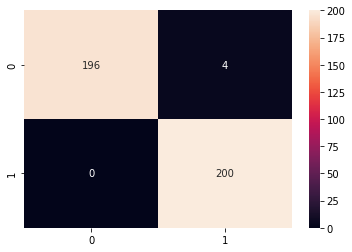

In [ ]:
import seaborn as sns
cm=confusion_matrix(y_test, lr.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g')

Even though the code is smaller, is still as powerful as the keras code and also very flexible. The most important part is the feature extraction, which `deepfeatx` take care for us, and the rest can be performed as any other ML problem.